In [7]:
#This Script is for Win Probability Simulation
#Before simulating,You need to edit the init.json

import pandas as pd
import numpy as np
import codecs
import sys
import json


def isServeIn(perServeIn, serve):
    return np.random.randint(0, 100) < perServeIn[serve]


def addGamePoint(perServe, serve, gamePoint, numServe, totalServe):
    totalServe[serve] += 1
    winlose = np.random.randint(0, 100) < perServe[serve]  # 0～99
    if(winlose):
        gamePoint[serve] += 1
        numServe[serve] += 1
    else:
        gamePoint[(serve + 1) % 2] += 1
    return gamePoint


def returnGameNext(gamePoint, serve, game):
    for i in range(2):
        if(gamePoint[i] > 3 and (gamePoint[i] - gamePoint[(i + 1) % 2]) > 1):
            game[i] += 1
            serve = (serve + 1) % 2
            gamePoint[0] = 0
            gamePoint[1] = 0
    return gamePoint, serve, game


def returnTiebreakNext(gameNum, gamePoint, serve, game, status, gameLog, sets):
    for i in range(2):
        if(gamePoint[i] > 6 and (gamePoint[i] - gamePoint[(i + 1) % 2]) > 1):
            status = 0
            game[i] += 1
            serve = (serve + 1) % 2
            gamePoint[0] = 0
            gamePoint[1] = 0

            gameLog.append([gameNum, game[0], game[1]])
            sets[i] += 1
            game[0] = 0
            game[1] = 0

    return gamePoint, serve, game, status, gameLog, sets


def returnSetNext(gameNum, game, serve, sets, status, gameLog):
    if((sets[0] + sets[1]) < 4 and game[0] == 6 and game[1] == 6):
        status = 1
    else:
        for i in range(2):
            if(game[i] > 5 and (game[i] - game[(i + 1) % 2]) > 1):
                gameLog.append([gameNum, game[0], game[1]])
                sets[i] += 1
                serve = (serve + 1) % 2
                game[0] = 0
                game[1] = 0
    return game, serve, sets, status, gameLog


def returnFinishNext(serve, sets, status, gameWon_array, setLog, setMatch):
    for i in range(2):
        if(sets[i] > setMatch - 1):
            setLog.append([sets[0], sets[1]])
            gameWon_array[i] += 1
            status = 2
    return status, gameWon_array, setLog


def createList(dftemp):
    list = [
        dftemp["1st Serve"],
        dftemp["1st Serve Points Won"],
        dftemp["2nd Serve Points Won"],
        dftemp["1st Serve Return Points Won"],
        dftemp["2nd Serve Return Points Won"]]
    return list


def calcWonPer(
        per1stServeIn,
        per2ndServeIn,
        p1_1,
        s1_1,
        p1_2,
        s1_2,
        p2_1,
        s2_1,
        p2_2,
        s2_2,
        numGames,
        gamePoint_start,
        game_start,
        sets_start):

    s = 0
    perGame_array = []
    stats_array = []

    num1stServe = [0, 0]
    num2ndServe = [0, 0]
    total1stServe = [0, 0]
    total2ndServe = [0, 0]
    gameWon_array = [0, 0]
    gameLog = []
    setLog = []

    for i in range(numGames):
        num1stServe = [0, 0]
        num2ndServe = [0, 0]
        total1stServe = [0, 0]
        total2ndServe = [0, 0]
        status = 0
        gamePoint = gamePoint_start[:]
        game = game_start[:]
        sets = sets_start[:]

        serve = np.random.randint(0, 2)
        dist1_1 = np.random.normal(p1_1, s1_1)
        dist2_1 = np.random.normal(p2_1, s2_1)
        dist1_2 = np.random.normal(p1_2, s1_2)
        dist2_2 = np.random.normal(p2_2, s2_2)

        per1stServe = [dist1_1, dist2_1]
        per2ndServe = [dist1_2, dist2_2]

        while status < 2:
            if(isServeIn(per1stServeIn, serve)):
                gamePoint = addGamePoint(
                    per1stServe, serve, gamePoint, num1stServe, total1stServe)
            else:
                if(isServeIn(per2ndServeIn, serve)):
                    gamePoint = addGamePoint(
                        per2ndServe, serve, gamePoint, num2ndServe, total2ndServe)
                else:
                    gamePoint[(serve + 1) % 2] += 1

            if(status == 1):
                gamePoint, serve, game, status, gameLog, sets = returnTiebreakNext(
                    i, gamePoint, serve, game, status, gameLog, sets)
            elif(status == 0):
                gamePoint, serve, game = returnGameNext(gamePoint, serve, game)

            game, serve, sets, status, gameLog = returnSetNext(
                i, game, serve, sets, status, gameLog)
            status, gameWon_array, setLog = returnFinishNext(
                serve, sets, status, gameWon_array, setLog, 2)

    wonPerA, wonPerB = round(
        gameWon_array[0] / numGames * 100, 1), round(gameWon_array[1] / numGames * 100, 1)
    return wonPerA, wonPerB


def calcPer(np_pointList):
    per = np.count_nonzero(np_pointList) * 100.0 / len(np_pointList)
    return per


def inOut(np_pointList, a):
    # pointList.pop(0)######todo numpy方式に変換
    np_pointList = np.delete(np_pointList, 0)
    np_pointList = np.append(np_pointList, a)  # pointList.append(a)
    return np_pointList


def calcPoint(ab1, ab2, df, serveIn, point_1st, point_2nd, gamePoint):  # ab1=1 Aのポイント ab2=1 Bのポイント
    gamePoint[ab2] += 1
    if(int(df['FirstSecond'][i]) == 1):
        serveIn = inOut(serveIn, 1)
        point_1st = inOut(point_1st, ab1)
    elif(int(df['FirstSecond'][i]) == 2):
        point_2nd = inOut(point_2nd, ab1)
    return point_1st, point_2nd


if __name__ == '__main__':
    f = open("init.json", 'r')
    json_data = json.load(f)

    playerNameA = json_data['playera']
    playerNameB = json_data['playerb']
    num = int(json_data['plength'] / 2)
    fileName = "data/"+json_data['file']
    nGames = json_data['ngamges']

    point_serveIn_A = np.array((1, 1) * num, dtype='uint8')#start as 100percentage
    point_serveIn_B = np.array((1, 1) * num, dtype='uint8')#start as 100percentage
    point_1st_A = np.array((0, 1) * num, dtype='uint8')#start as 50percentage
    point_1st_B = np.array((0, 1) * num, dtype='uint8')#start as 50percentage
    point_2nd_A = np.array((0, 1) * num, dtype='uint8')#start as 50percentage
    point_2nd_B = np.array((0, 1) * num, dtype='uint8')#start as 50percentage

    with codecs.open(fileName, "r", "SJIS", "ignore") as file:
        df = pd.read_table(file, delimiter=",")
    df['FirstSecond'] = df['FirstSecond'].convert_objects(
        convert_numeric=True).fillna(-1).astype(np.int)
    df = df.reset_index()

    gameLog = []
    setLog = []
    gamePoint = [0, 0]
    game = [0, 0]
    sets = [0, 0]

    pointA_array = []
    pointB_array = []

    gameA_array = []
    setA_array = []
    gameB_array = []
    setB_array = []

    flow_array = []
    point1st_array = []
    point2nd_array = []
    status = 0
    serve = 0

    for i in range(len(df)):
        print("Point",i)
        if(df['Server'][i] == playerNameA):
            point_1st_A, point_2nd_A = calcPoint(int(df['WonA'][i]), (int(
                df['WonA'][i]) + 1) % 2, df, point_serveIn_A, point_1st_A, point_2nd_A, gamePoint)
            serve = 0
        elif(df['Server'][i] == playerNameB):
            point_1st_B, point_2nd_B = calcPoint(
                (int(
                    df['WonA'][i]) + 1) %
                2, (int(
                    df['WonA'][i]) + 1) %
                2, df, point_serveIn_B, point_1st_B, point_2nd_B, gamePoint)
            serve = 1

        if(status == 1):
            gamePoint, serve, game, status, gameLog, sets = returnTiebreakNext(
                i, gamePoint, serve, game, status, gameLog, sets)
        elif(status == 0):
            gamePoint, serve, game = returnGameNext(gamePoint, serve, game)

        game, serve, sets, status, gameLog = returnSetNext(
            i, game, serve, sets, status, gameLog)
        # status,gameWon_array,setLog=returnFinishNext(serve,sets,status,gameWon_array,setLog,3)
        
        #print(i+2,sets,game)

        per_serveIn_A = round(calcPer(point_serveIn_A), 1)
        per_serveIn_B = round(calcPer(point_serveIn_B), 1)

        per_point1st_A = round(calcPer(point_1st_A), 1)
        per_point2nd_A = round(calcPer(point_2nd_A), 1)

        per_point1st_B = round(calcPer(point_1st_B), 1)
        per_point2nd_B = round(calcPer(point_2nd_B), 1)

        pointA_array.append(gamePoint[0])
        pointB_array.append(gamePoint[1])

        gameA_array.append(game[0])
        setA_array.append(sets[0])
        gameB_array.append(game[1])
        setB_array.append(sets[1])

        flow_array.append(calcWonPer([per_serveIn_A,
                                      per_serveIn_B],
                                     [100,
                                      100],
                                     per_point1st_A,
                                     8.2,
                                     per_point2nd_A,
                                     10.8,
                                     per_point1st_B,
                                     8.2,
                                     per_point2nd_B,
                                     10.8,
                                     nGames,
                                     gamePoint,
                                     game,
                                     sets))

        point1st_array.append([per_point1st_A, per_point1st_B])
        point2nd_array.append([per_point2nd_A, per_point2nd_B])
        #print(flow_array)
    #df_add = pd.DataFrame({'PointA':pointA_array,'PointB':pointB_array,'GameA':gameA_array,'GameB':gameB_array,'SetA':setA_array,'SetB':setB_array})
    fileName=fileName.replace(".csv","")
    np.savetxt(fileName + '_output.csv', np.array(flow_array), delimiter=',')
    print("Complete")


C:\Users\taku\Anaconda3\lib\site-packages\ipykernel\__main__.py:202: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


Point 0
Point 1
Point 2
Point 3
Point 4
Point 5
Point 6
Point 7
Point 8
Point 9
Point 10
Point 11
Point 12
Point 13
Point 14
Point 15
Point 16
Point 17
Point 18
Point 19
Point 20
Point 21
Point 22
Point 23
Point 24
Point 25
Point 26
Point 27
Point 28
Point 29
Point 30
Point 31
Point 32
Point 33
Point 34
Point 35
Point 36
Point 37
Point 38
Point 39
Point 40
Point 41
Point 42
Point 43
Point 44
Point 45
Point 46
Point 47
Point 48
Point 49
Point 50
Point 51
Point 52
Point 53
Point 54
Point 55
Point 56
Point 57
Point 58
Point 59
Point 60
Point 61
Point 62
Point 63
Point 64
Point 65
Point 66
Point 67
Point 68
Point 69
Point 70
Point 71
Point 72
Point 73
Point 74
Point 75
Point 76
Point 77
Point 78
Point 79
Point 80
Point 81
Point 82
Point 83
Point 84
Point 85
Point 86
Point 87
Point 88
Point 89
Point 90
Point 91
Point 92
Point 93
Point 94
Point 95
Point 96
Point 97
Point 98
Point 99
Point 100
Point 101
Point 102
Point 103
Point 104
Point 105
Point 106
Point 107
Point 108
Point 109
Point 110


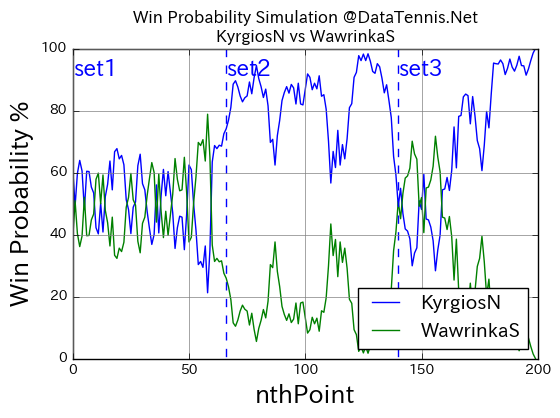

In [8]:
#Create Graph as png file
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

if __name__ == '__main__':
    f = open("init.json", 'r')
    json_data = json.load(f)

    fileName = json_data['file']
    fileName=fileName.replace(".csv","")
    playerA = json_data['playera']
    playerB = json_data['playerb']

    flow_array = np.loadtxt("data/"+fileName + "_output.csv", delimiter=",")
    plen = len(flow_array)

    plt.plot(flow_array)

    df['diff'] = (df['Set'] - df['Set'].shift(1)).fillna(0)
    df_temp = df[df['diff'] == 1].index
    for i, d in enumerate(df_temp):
        plt.plot([d, d], [-10, 110], "blue", linestyle='dashed')
        plt.text(
            d,
            90,
            'set%d' % (i + 2),
            ha='left',
            va='bottom',
            color='blue',
            fontsize=16)

    plt.grid(which='major', color='gray', linestyle='-')
    plt.text(0, 90, 'set1', ha='left', va='bottom', color='blue', fontsize=16)

    plt.title(
        "Win Probability Simulation @DataTennis.Net\n" +
        playerA +
        " vs " +
        playerB)
    plt.xlabel("nthPoint", fontsize=18)
    plt.ylabel("Win Probability %", fontsize=18)

    plt.xlim([0, plen])
    plt.ylim([0, 100])

    plt.legend([playerA, playerB], fontsize=14, loc='lower right')
    plt.savefig("data/"+fileName + '_graph.png')


3


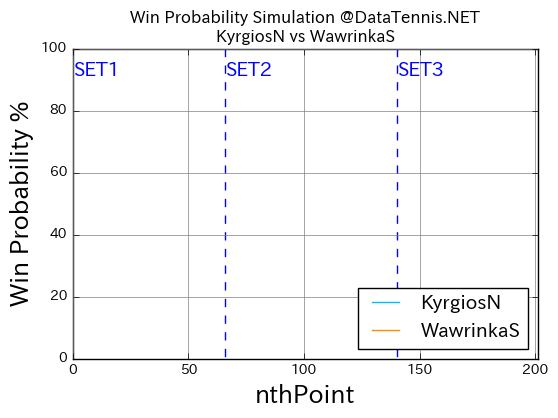

In [9]:
#Create Animation Graph as gif file
import numpy as np
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import json
import pandas as pd
%matplotlib inline

if __name__ == '__main__':
    f = open("init.json", 'r')
    json_data = json.load(f)

    fileName = json_data['file']
    fileName=fileName.replace(".csv","")
    playerA = json_data['playera']
    playerB = json_data['playerb']
    set1 = json_data['set1']
    set2 = json_data['set2']
    set3 = json_data['set3']
    

    flow_array = np.loadtxt("data/"+fileName + "_output.csv", delimiter=",")
    plen = len(flow_array)

    temp1 = []
    temp2 = []
    for i in range(len(flow_array)):
        temp1.append(flow_array[i][0])
        temp2.append(flow_array[i][1])

    y1 = np.array(temp1)
    y2 = np.array(temp2)
    x = np.array(range(len(flow_array)))

    fig = plt.figure()

    df['diff'] = (df['Set'] - df['Set'].shift(1)).fillna(0)
    df_temp = df[df['diff'] == 1].index
    
    totalset=len(df_temp)+1
    print(totalset)

    ims = []
    for i in range(0, len(flow_array)):
        if(i==0):
            i=len(flow_array)-1
        im1, = plt.plot(x[:i], y1[:i], "#00bfff")##00bfff
        im2, = plt.plot(x[:i], y2[:i], "#FF8C00")#FF8C00
        im3, = plt.plot(x[i],y1[i],marker="o",markerfacecolor="#00bfff",markeredgewidth =0.0)
        im4, = plt.plot(x[i],y2[i],marker="o",markerfacecolor="#FF8C00",markeredgewidth =0.0)
        if(totalset==2):
            if(i < (df_temp[0]-1)):
                s1 = 'GAME %d-%d' % (gameA_array[i], gameB_array[i])
                s2 = ''
            elif(i >= (df_temp[0]-1) and i < (len(flow_array)-1)):
                s1 = 'GAME ' + set1
                s2 = 'GAME %d-%d' % (gameA_array[i], gameB_array[i])
            else:
                s1 = 'GAME ' + set1
                s2 = 'GAME ' + set2
            im5 = plt.text(
                0,
                80,
                s1,
                ha='left',
                va='bottom',
                color='blue',
                fontsize=14)
            im6 = plt.text(
                df_temp[0],
                80,
                s2,
                ha='left',
                va='bottom',
                color='blue',
                fontsize=14)
            ims.append([im1, im2,im3, im4,  im5, im6])
        elif(totalset==3):
            if(i < (df_temp[0]-1)):
                s1 = 'GAME %d-%d' % (gameA_array[i], gameB_array[i])
                s2 = ''
                s3 = ''
            elif(i >= (df_temp[0]-1) and i < (df_temp[1]-1)):
                s1 = 'GAME ' + set1
                s2 = 'GAME %d-%d' % (gameA_array[i], gameB_array[i])
                s3 = ''
            elif(i > (df_temp[1]-1) and i < (len(flow_array)-1)):
                s1 = 'GAME ' + set1
                s2 = 'GAME ' + set2
                s3 = 'GAME %d-%d' % (gameA_array[i], gameB_array[i])
            else:
                s1 = 'GAME ' + set1
                s2 = 'GAME ' + set2
                s3 = 'GAME ' + set3
            im5 = plt.text(
                0,
                80,
                s1,
                ha='left',
                va='bottom',
                color='blue',
                fontsize=14)
            im6 = plt.text(
                df_temp[0],
                80,
                s2,
                ha='left',
                va='bottom',
                color='blue',
                fontsize=14)
            im7 = plt.text(
                df_temp[1],
                80,
                s3,
                ha='left',
                va='bottom',
                color='blue',
                fontsize=14)
            ims.append([im1, im2,im3, im4,  im5, im6, im7])

    for i, d in enumerate(df_temp):
        plt.plot([d, d], [-10, 110], "blue", linestyle='dashed')  # SETの境界線
        plt.text(
            d,
            90,
            'SET%d' % (i + 2),
            ha='left',
            va='bottom',
            color='blue',
            fontsize=14)

    plt.grid(which='major', color='gray', linestyle='-')
    plt.text(0, 90, 'SET1', ha='left', va='bottom', color='blue', fontsize=14)

    plt.title(
        "Win Probability Simulation @DataTennis.NET\n" +
        playerA +
        " vs " +
        playerB)
    plt.xlabel("nthPoint", fontsize=18)
    plt.ylabel("Win Probability %", fontsize=18)

    plt.xlim([0, plen+1])
    plt.ylim([0, 100])

    plt.legend([playerA, playerB], fontsize=14, loc='lower right')

    ani = animation.ArtistAnimation(fig, ims, interval=200)  # 33
    ani.save("data/"+fileName + '_graph.gif', writer='imagemagick')
